# Propensity Score Estimation via XGBoost

This script estimates propensity scores using XGBoost within a one-vs-rest framework.  
For each treatment level \( j \), the model estimates:

\[
\hat{\pi}_{ij} = P(A_i = j \mid X_i)
\]

where \( A_i \) denotes the observed treatment (ad) and \( X_i \) represents the covariates.

### Model Estimation

- XGBoost is trained under a cross-validation scheme.
- 5-fold stratified splits are used.
- Out-of-fold (OOF) predictions are collected to obtain unbiased propensity estimates for all observations.
- Class imbalance is handled through appropriate weighting inside the model.

The result is an \( N \times J \) matrix of estimated propensity scores.

### Feasibility Constraint

A support mask (FLT) enforces structural feasibility: treatments that are not possible in a given context receive zero probability.  
After zeroing infeasible probabilities, scores are clipped and row-normalized to ensure:

\[
\sum_{j} \hat{\pi}_{ij}^{adj} = 1.
\]

### Balance Diagnostics

Standardized Bias (SB) is computed before and after inverse-propensity weighting:

\[
SB = \frac{|\mu_{treat} - \mu_{pop}|}{\sigma_{pop}}.
\]

Inverse-propensity weights \( w_i = 1 / \hat{\pi}_{ij} \) are used to assess covariate balance.

A Love plot summarizes maximum absolute standardized bias per covariate before and after weighting.

### Output

The adjusted propensity scores \( \hat{\pi}_{ij}^{adj} \) are exported for downstream causal estimation, weighting, or off-policy evaluation.


In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score
import warnings; warnings.filterwarnings("ignore", category=UserWarning)

EPSILON, BALANCE_THRESHOLD, N_FOLDS = 1e-9, 0.20, 5
XGB_PARAMS = dict(
    objective="binary:logistic", eval_metric="logloss",
    learning_rate=0.1, max_depth=9, n_estimators=300,
    subsample=0.5, reg_alpha=5, colsample_bytree=0.5,
    min_child_weight=5, gamma=7, tree_method="hist",
    n_jobs=-1, early_stopping_rounds=40,
)
plt.rcParams.update({"figure.dpi": 120})

def sb(X_treat, X_pop, w=None):
    pop_mu = np.mean(X_pop, axis=0)
    pop_sd = np.std (X_pop, axis=0)
    pop_sd[pop_sd < EPSILON] = np.nan
    treat_mu = (np.average(X_treat, axis=0, weights=w)
                if w is not None else np.mean(X_treat, axis=0))
    return np.nan_to_num(np.abs(treat_mu - pop_mu) / pop_sd, nan=0.)

print("1. Loading data …")
df_orig   = pd.read_csv("preprocessed_test_data.csv", low_memory=False)
ID_FILE   = "Models0/val_counterfactual_predictions_Behavioral.csv"
valid_ids = pd.read_csv(ID_FILE, usecols=["Unique_ID"])["Unique_ID"].unique()
df_orig   = df_orig[df_orig["Unique_ID"].isin(valid_ids)].reset_index(drop=True)
df, N     = df_orig.copy(), len(df_orig)

print("2. Feature engineering …")
ads     = sorted(df["CURRENT_AD_ID"].unique())
ad2idx  = {ad:i for i, ad in enumerate(ads)}
idx2ad  = {i:ad for ad,i in ad2idx.items()}
nc      = len(ads)

df["hd_numeric"]    = (np.floor(df["TIME"] / 3600) - 486).astype(int)
df["br_numeric"]    = pd.factorize(df["BRAND_ID"])[0]
df["ct_numeric"]    = pd.factorize(df["DATA"])[0]
df["ms_numeric"]    = pd.factorize(df["OPERATOR_ID"])[0]
df["st_numeric"]    = pd.factorize(df["PROVINCE"])[0]
df["appid_numeric"] = pd.factorize(df["MEDIA_PACKAGE_NAME"])[0]

y_onehot = np.zeros((N, nc), int)
for i, ad in enumerate(df["CURRENT_AD_ID"]):
    y_onehot[i, ad2idx[ad]] = 1
y_multiclass = y_onehot.argmax(1)

def build_support(col):
    levels = np.sort(df[col].unique())
    mapper = {v:i for i, v in enumerate(levels)}
    mat    = np.zeros((len(levels), nc), int)
    for v, grp in df.groupby(col):
        mat[mapper[v]] = (y_onehot[grp.index].sum(0) > 0).astype(int)
    return mat, mapper

print("4. Building support matrices …")
hdmat , hdmap  = build_support("hd_numeric")
brmat , brmap  = build_support("br_numeric")
ctmat , ctmap  = build_support("ct_numeric")
msmat , msmap  = build_support("ms_numeric")
stmat , stmap  = build_support("st_numeric")
apmat , apmap  = build_support("appid_numeric")

def pick(mat, col_vals, mapper):
    return mat[col_vals.map(mapper).to_numpy()]

FLT = (pick(stmat , df["st_numeric" ], stmap) *
       pick(hdmat , df["hd_numeric" ], hdmap) *
       pick(ctmat , df["ct_numeric" ], ctmap) *
       pick(brmat , df["br_numeric" ], brmap) *
       pick(msmat , df["ms_numeric" ], msmap) *
       pick(apmat , df["appid_numeric"], apmap)).astype(int)

base_cols = ["hd_numeric","br_numeric","ct_numeric","ms_numeric",
             "st_numeric","appid_numeric",
             "PROVINCE","DAY","HOUR","TIME",
             "LATITUDE","LONGITUDE","ANDROID_ID_COUNT","FRAUD_CODE", "DEVICE_ID"]
base_cols = [c for c in base_cols if c in df.columns]

X_base = df[base_cols].copy()
for c in X_base.columns:
    if X_base[c].isnull().any():
        X_base[c] = (X_base[c].fillna(X_base[c].median())
                     if pd.api.types.is_numeric_dtype(X_base[c])
                     else X_base[c].fillna(X_base[c].mode()[0]))

flt_cols = [f"flt_ad_{idx2ad[i]}" for i in range(nc)]
X_model  = pd.concat([X_base, pd.DataFrame(FLT, columns=flt_cols)], axis=1)

X_bal    = X_base.values

plain_SB = np.zeros((len(X_base.columns), nc))
for j in range(nc):
    elig   = np.where(FLT[:, j] == 1)[0]
    treat  = elig[y_onehot[elig, j] == 1]
    plain_SB[:, j] = (sb(X_bal[treat], X_bal[elig]) if treat.size else np.nan)

plain_SB_all      = np.zeros((len(X_base.columns), nc))
plain_SB_eligible = np.zeros((len(X_base.columns), nc))
for j in range(nc):
    elig  = np.where(FLT[:, j] == 1)[0]
    treat = np.where(y_onehot[:, j] == 1)[0]
    plain_SB_all[:, j]      = sb(X_bal[treat], X_bal) if treat.size else np.nan
    plain_SB_eligible[:, j] = (sb(X_bal[treat], X_bal[elig])
                               if (treat.size and elig.size) else np.nan)

print("7. Training binary models …")
prop   = np.zeros((N, nc))
cv_ll  = []
ad_acc = np.full(nc, np.nan)
ad_auc = np.full(nc, np.nan)

for j in range(nc):
    y_bin = y_onehot[:, j]
    pos   = y_bin.sum()
    neg   = N - pos
    if pos == 0:
        print(f"  Ad {idx2ad[j]}: never shown → skipped")
        continue
    scale   = neg / pos
    samp_w  = np.where(y_bin == 1, scale, 1.0)

    oof = np.zeros(N)
    skf = StratifiedKFold(N_FOLDS, shuffle=True, random_state=42)

    for fold, (tr, va) in enumerate(skf.split(X_model, y_bin), 1):
        clf = XGBClassifier(**XGB_PARAMS,
                            random_state=100 + j + fold,
                            scale_pos_weight=scale)
        clf.fit(X_model.iloc[tr], y_bin[tr],
                sample_weight=samp_w[tr],
                eval_set=[(X_model.iloc[va], y_bin[va])],
                verbose=False)
        p_val    = clf.predict_proba(X_model.iloc[va])[:, 1]
        oof[va]  = p_val
        cv_ll.append(log_loss(y_bin[va], p_val, sample_weight=samp_w[va]))

    prop[:, j] = oof
    ad_acc[j]  = accuracy_score(y_bin, (oof >= 0.5).astype(int))
    ad_auc[j]  = roc_auc_score(y_bin, oof)

    print(f"  Ad {idx2ad[j]}: log-loss {log_loss(y_bin, oof):.4f}  "
          f"ACC {ad_acc[j]:.3f}  AUC {ad_auc[j]:.3f}  "
          f"(scale_pos_weight={scale:.1f})")

print(f"\n☆ Mean CV log-loss = {np.mean(cv_ll):.4f}")
print(f"☆ Mean accuracy    = {np.nanmean(ad_acc):.3f}")
print(f"☆ Mean AUC         = {np.nanmean(ad_auc):.3f}")

prop[FLT == 0]        = 0.0
prop[prop < EPSILON]  = 0.0
rowsum = prop.sum(1, keepdims=True)
rowsum[rowsum == 0]   = 1.0
prop_adj = prop / rowsum

adj_SB = np.zeros((len(X_base.columns), nc))
for j in range(nc):
    elig  = np.where(FLT[:, j] == 1)[0]
    treat = elig[y_onehot[elig, j] == 1]
    if not treat.size:
        adj_SB[:, j] = np.nan
        continue
    w = 1.0 / (prop_adj[treat, j] + EPSILON)
    adj_SB[:, j] = sb(X_bal[treat], X_bal[elig], w)

max_plain = np.nanmax(plain_SB_all, 1)
max_adj   = np.nanmax(adj_SB, 1)

print("\n── Max |SB| before weighting ──")
print(pd.DataFrame({"feature": X_base.columns,
                    "max_SB_plain": max_plain}).to_string(index=False))
print("\n── Max |SB| after  weighting ──")
print(pd.DataFrame({"feature": X_base.columns,
                    "max_SB_adj":   max_adj }).to_string(index=False))

love_df = pd.DataFrame({"Before": max_plain, "After": max_adj}, index=X_base.columns)
plt.figure(figsize=(6, len(X_base.columns)*0.35 + 1))
plt.hlines(y=love_df.index, xmin=0, xmax=love_df.values.max()*1.05,
           color="lightgray")
plt.plot(love_df["Before"], love_df.index, "o", label="Before")
plt.plot(love_df["After"],  love_df.index, "o", label="After")
plt.axvline(BALANCE_THRESHOLD, ls="--", color="red")
plt.xlabel("|Standardised Bias|"); plt.title("Love plot: covariate balance")
plt.legend(); plt.tight_layout(); plt.show()

print("\n11. Saving π̂ histograms & box-plots …")
per_fig = 9
for fig in range(int(np.ceil(nc / per_fig))):
    plt.figure(figsize=(14, 12))
    for k, j in enumerate(range(fig*per_fig, min((fig+1)*per_fig, nc)), 1):
        plt.subplot(3, 3, k)
        plt.hist(prop_adj[:, j], bins=20, range=(0, 1),
                 density=True, alpha=0.7)
        plt.title(f"Ad {idx2ad[j]} (hist)")
    plt.tight_layout(); plt.show()

    ads_range = range(fig*per_fig, min((fig+1)*per_fig, nc))
    plt.figure(figsize=(10, 6))
    plt.boxplot([prop_adj[:, j] for j in ads_range], vert=False,
                labels=[f"Ad {idx2ad[j]}" for j in ads_range],
                showfliers=False)
    plt.xlabel("π̂"); plt.title("Propensity distributions (box-plot)", fontsize=20)
    plt.tight_layout(); plt.show()

cols = [f"pi_hat_ad_{idx2ad[j]}" for j in range(nc)]
out  = pd.DataFrame(prop_adj, columns=cols)
out.insert(0, "Unique_ID", df_orig["Unique_ID"])
out.to_csv("propensity_scores_estimation.csv", index=False)

try:
    macro_auc = roc_auc_score(y_multiclass, prop_adj,
                              multi_class="ovr", average="macro")
    print(f"Diagnostic macro AUC (OVR) = {macro_auc:.4f}")
except ValueError:
    pass


## Propensity Score Diagnostics and IPS Evaluation (Figure A.1)

After estimating propensity scores, this script conducts a structured diagnostic and evaluation pipeline to assess their quality and suitability for inverse-probability weighting. It begins with basic sanity checks, verifying that row sums are close to one, that no invalid values (NaNs or out-of-range probabilities) are present, and that extremely small propensities are handled appropriately. Propensity values below a predefined threshold \( \epsilon \) are treated as effectively unusable and set to `NaN`, ensuring that unstable weights do not distort downstream analysis.

The script then examines the distribution of the retained propensities. Summary statistics (count, mean, standard deviation, minimum, maximum) are computed, and weighted boxplots are constructed using inverse-propensity weights \( w = 1/\hat{\pi} \). Predictive diagnostics—including AUC, accuracy, log-loss, and Brier score—are evaluated on eligible observations, with both macro and micro averages reported to summarize overall performance. These metrics assess whether the estimated propensities meaningfully distinguish treatment assignments.

Next, the effective sample size (ESS) is computed as
\[
\text{ESS} = \frac{(\sum_i w_i)^2}{\sum_i w_i^2},
\]
which quantifies variance inflation induced by weighting. ESS provides a practical measure of how much information remains after applying inverse-probability weights.

Using the filtered propensities, the script evaluates the always-pick treatment policy via inverse propensity scoring. Baseline click-through rate (CTR), empirical CTR, and IPS-adjusted CTR are compared, and relative lift over baseline is reported. This allows a direct comparison between naive empirical outcomes and debiased IPS estimates.

Finally, covariate balance is reassessed by computing standardized bias (SB) before and after weighting:
\[
SB = \frac{|\mu_{treat} - \mu_{pop}|}{\sigma_{pop}}.
\]
Maximum absolute SB across covariates is reported to verify that weighting improves balance, typically using a threshold such as \( |SB| < 0.20 \). This step confirms that the propensity model not only predicts assignment well but also supports credible causal evaluation through improved covariate alignment.

Together, these diagnostics ensure that the estimated propensity scores are numerically stable, predictive, variance-aware, and capable of supporting valid IPS-based policy evaluation.



╭─ Propensity sanity checks (raw) ────────────────────────────
Rows with |Σπ̂−1|>1e-3 : 0 / 3162376
NaNs in π̂            : 0
π̂ < 0                : 0
π̂ > 1                : 0

Filtering: set π̂ < 1e-09 to NaN   → dropped cells: 12,978,213

Per-ad π̂ summary after filtering (head):
         count    mean     std     min  max
Ad_ID                                      
0      1215402  0.1366  0.0460  0.0104  1.0
1      3150339  0.1761  0.0494  0.0927  1.0
2      3149814  0.1766  0.0494  0.0939  1.0
3       921761  0.2042  0.0546  0.0054  1.0
4       794563  0.1642  0.0440  0.0097  1.0
5      3151146  0.1749  0.0491  0.0925  1.0
6      2047802  0.1702  0.0570  0.0070  1.0
7      1960117  0.1653  0.0305  0.0623  1.0
8      1221548  0.1350  0.0484  0.0115  1.0
9      1033055  0.1721  0.0327  0.0291  1.0
✓ Saved propensity_summary_filtered.png

────────  Macro / Micro averages (ads with valid metrics) ────────
Macro-avg  AUC   : 0.6335
Micro-avg  AUC   : 0.6276
Macro-avg  ACC   : 0.7968


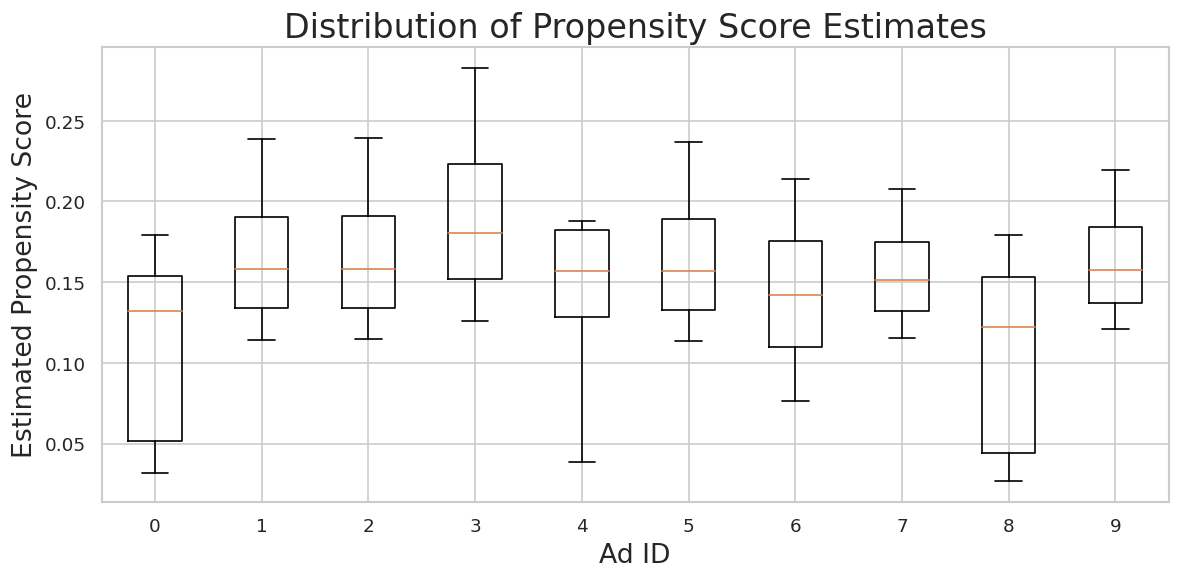

In [4]:
from pathlib import Path
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_auc_score, accuracy_score, log_loss, brier_score_loss
)

PROP_FILE = Path("propensity_scores.csv")

EVAL_FILE = Path(f"Models2/val_counterfactual_predictions_Behavioral.csv")
EPSILON   = 1e-9
EPSILONN  = 0.98

PLOT_DPI  = 120

sns.set(style="whitegrid")
plt.rcParams.update({"figure.dpi": PLOT_DPI})

def sb(X_treat, X_pop, w=None):
    pop_mu = np.mean(X_pop, axis=0)
    pop_sd = np.std (X_pop, axis=0)
    pop_sd[pop_sd < EPSILON] = np.nan
    pop_sd[pop_sd > EPSILONN] = np.nan

    treat_mu = (np.average(X_treat, axis=0, weights=w)
                if w is not None else np.mean(X_treat, axis=0))
    return np.nan_to_num(np.abs(treat_mu - pop_mu) / pop_sd, nan=0.)

prop_df = pd.read_csv(PROP_FILE)
eval_df = pd.read_csv(EVAL_FILE)

pi_cols = sorted([c for c in prop_df.columns if c.startswith("pi_hat_ad_")],
                 key=lambda s: int(s.split("_")[-1]))
ad_ids  = [int(c.split("_")[-1]) for c in pi_cols]

df = (
    eval_df[["Unique_ID", "Actual_Ad_ID", "Actual_Y"]]
    .merge(prop_df[["Unique_ID"] + pi_cols], on="Unique_ID", validate="1:1")
    .reset_index(drop=True)
)

n         = len(df)
pi_hat    = df[pi_cols].to_numpy()
Y         = df["Actual_Y"].to_numpy()
A_actual  = df["Actual_Ad_ID"].to_numpy()

print("\n╭─ Propensity sanity checks (raw) ────────────────────────────")
row_sums = pi_hat.sum(axis=1)
print(f"Rows with |Σπ̂−1|>1e-3 : {(np.abs(row_sums-1) > 1e-3).sum():,} / {n}")
print(f"NaNs in π̂            : {np.isnan(pi_hat).sum():,}")
print(f"π̂ < 0                : {(pi_hat < -1e-12).sum():,}")
print(f"π̂ > 1                : {(pi_hat > 1+1e-6).sum():,}")

pi_kept      = np.where(pi_hat >= EPSILON, pi_hat, np.nan)
kept_mask    = ~np.isnan(pi_kept)
kept_counts  = kept_mask.sum(axis=0)
dropped      = kept_mask.size - kept_counts.sum()

print(f"\nFiltering: set π̂ < {EPSILON} to NaN   → dropped cells: {dropped:,}")

summary = (
    pd.DataFrame(pi_kept, columns=ad_ids)
      .agg(["count", "mean", "std", "min", "max"])
      .T.rename_axis("Ad_ID")
)
summary["count"] = summary["count"].astype(int)

print("\nPer-ad π̂ summary after filtering (head):")
print(summary.head(10).round(4))

plt.figure(figsize=(10, 5))

def _weighted_quantile(values, quantiles, sample_weight=None):
    values = np.asarray(values, dtype=float)
    quantiles = np.asarray(quantiles, dtype=float)
    if sample_weight is None:
        sample_weight = np.ones_like(values)
    else:
        sample_weight = np.asarray(sample_weight, dtype=float)
    mask = ~np.isnan(values) & ~np.isnan(sample_weight)
    values = values[mask]
    sample_weight = sample_weight[mask]
    if values.size == 0:
        return np.array([np.nan] * len(quantiles))
    order = np.argsort(values)
    values = values[order]
    sample_weight = sample_weight[order]
    cum_w = np.cumsum(sample_weight)
    cum_w /= cum_w[-1]
    return np.interp(quantiles, cum_w, values)

bxp_stats = []
for j, a in enumerate(ad_ids):
    x = pi_kept[:, j]
    x = x[~np.isnan(x)]
    if x.size == 0:
        bxp_stats.append({"label": str(a), "whislo": np.nan, "q1": np.nan,
                          "med": np.nan, "q3": np.nan, "whishi": np.nan})
        continue
    w = 1.0 / x
    q1, med, q3 = _weighted_quantile(x, [0.25, 0.50, 0.75], w)
    lo, hi      = _weighted_quantile(x, [0.05, 0.90], w)
    bxp_stats.append({"label": str(a), "whislo": lo, "q1": q1,
                      "med": med, "q3": q3, "whishi": hi})

ax = plt.gca()
ax.bxp(bxp_stats, showfliers=False)
plt.title(f"Distribution of Propensity Score Estimates", fontsize=20)
plt.xlabel("Ad ID", fontsize=16); plt.ylabel("Estimated Propensity Score", fontsize=16)
plt.tight_layout()
print("✓ Saved propensity_summary_filtered.png")

metrics_rows = []
for j, a in enumerate(ad_ids):
    elig = ~np.isnan(pi_kept[:, j])
    y_bin = (A_actual == a).astype(int)

    if elig.sum() == 0 or y_bin[elig].sum() == 0 or y_bin[elig].sum() == elig.sum():
        metrics_rows.append({"Ad_ID": a, "eligible_n": elig.sum(),
                             "AUC": np.nan, "ACC": np.nan,
                             "log_loss": np.nan, "Brier": np.nan})
        continue

    prob  = pi_kept[elig, j]
    auc   = roc_auc_score(y_bin[elig], prob)
    acc   = accuracy_score(y_bin[elig], (prob >= 0.5))
    ll    = log_loss(y_bin[elig], prob, labels=[0, 1])
    br    = brier_score_loss(y_bin[elig], prob)

    metrics_rows.append({"Ad_ID": a, "eligible_n": elig.sum(),
                         "AUC": auc, "ACC": acc,
                         "log_loss": ll, "Brier": br})

metrics_df = pd.DataFrame(metrics_rows).set_index("Ad_ID")
#print("\nPer-ad predictive metrics  (eligible rows only, π̂ ≥ ε):")
#print(metrics_df.round(4).head(10))

valid = metrics_df.dropna()
macro = valid.mean()
micro_weights = valid["eligible_n"] / valid["eligible_n"].sum()
micro = (valid[["AUC", "ACC", "log_loss", "Brier"]].T
         @ micro_weights).to_dict()

print("\n────────  Macro / Micro averages (ads with valid metrics) ────────")
print(f"Macro-avg  AUC   : {macro['AUC']:.4f}")
print(f"Micro-avg  AUC   : {micro['AUC']:.4f}")
print(f"Macro-avg  ACC   : {macro['ACC']:.4f}")
print(f"Micro-avg  ACC   : {micro['ACC']:.4f}")
print(f"Macro-avg  log-loss : {macro['log_loss']:.5f}")
print(f"Micro-avg  log-loss : {micro['log_loss']:.5f}")
print(f"Macro-avg  Brier : {macro['Brier']:.5f}")
print(f"Micro-avg  Brier : {micro['Brier']:.5f}")

ess_vals = []
for j, a in enumerate(ad_ids):
    good = ~np.isnan(pi_kept[:, j])
    w    = np.zeros_like(Y, dtype=float)
    w[good] = 1.0 / pi_kept[good, j]
    ess = (w.sum())**2 / (w**2).sum() if good.any() else 0
    ess_vals.append(ess)

metrics_df['ESS'] = ess_vals

combined_df = summary.join(metrics_df)
print("\nCombined Per-Ad Statistics and Metrics Table:")
print(combined_df.round(4).to_string())

macro_ess = np.mean(ess_vals)
micro_ess = np.average(ess_vals, weights=kept_counts)
print(f"\nMacro-avg ESS: {macro_ess:.2f}")
print(f"Micro-avg ESS: {micro_ess:.2f}")

baseline_ctr   = Y.mean()
empirical_ctrs = np.array([
    Y[A_actual == a].mean() if (A_actual == a).any() else np.nan
    for a in ad_ids
])

ips_vals = []
for j, a in enumerate(ad_ids):
    mask_actual   = (A_actual == a)
    mask_good     = mask_actual & ~np.isnan(pi_kept[:, j])
    if not mask_good.any():
        ips_vals.append(np.nan)
        continue
    w             = 1.0 / pi_kept[mask_good, j]
    ips_vals.append(w.dot(Y[mask_good]) / n)

ips_vals = np.array(ips_vals)
lift_pct = (ips_vals - baseline_ctr) / baseline_ctr * 100


print("\n╭─ Covariate Balance Check ────────────────────────────────────")
df_full = pd.read_csv("preprocessed_test_data.csv", low_memory=False)
df_full = df_full[df_full["Unique_ID"].isin(df["Unique_ID"])].reset_index(drop=True)

df_full["hd_numeric"]    = (np.floor(df_full["TIME"] / 3600) - 486).astype(int)
df_full["br_numeric"]    = pd.factorize(df_full["BRAND_ID"])[0]
df_full["ct_numeric"]    = pd.factorize(df_full["DATA"])[0]
df_full["ms_numeric"]    = pd.factorize(df_full["OPERATOR_ID"])[0]
df_full["st_numeric"]    = pd.factorize(df_full["PROVINCE"])[0]
df_full["appid_numeric"] = pd.factorize(df_full["MEDIA_PACKAGE_NAME"])[0]

ad2idx = {ad: i for i, ad in enumerate(ad_ids)}
y_onehot = np.zeros((n, len(ad_ids)), int)
for i, ad in enumerate(A_actual):
    if ad in ad2idx:
        y_onehot[i, ad2idx[ad]] = 1

def build_support(col):
    levels = np.sort(df_full[col].unique())
    mapper = {v: i for i, v in enumerate(levels)}
    mat = np.zeros((len(levels), len(ad_ids)), int)
    for v, grp in df_full.groupby(col):
        mat[mapper[v]] = (y_onehot[grp.index].sum(0) > 0).astype(int)
    return mat, mapper

hdmat, hdmap = build_support("hd_numeric")
brmat, brmap = build_support("br_numeric")
ctmat, ctmap = build_support("ct_numeric")
msmat, msmap = build_support("ms_numeric")
stmat, stmap = build_support("st_numeric")
apmat, apmap = build_support("appid_numeric")

def pick(mat, col_vals, mapper):
    return mat[col_vals.map(mapper).to_numpy()]

FLT = (pick(stmat, df_full["st_numeric"], stmap) *
       pick(hdmat, df_full["hd_numeric"], hdmap) *
       pick(ctmat, df_full["ct_numeric"], ctmap) *
       pick(brmat, df_full["br_numeric"], brmap) *
       pick(msmat, df_full["ms_numeric"], msmap) *
       pick(apmat, df_full["appid_numeric"], apmap)).astype(int)

base_cols = ["hd_numeric", "br_numeric", "ct_numeric", "ms_numeric",
             "st_numeric", "appid_numeric",
             "PROVINCE", "DAY", "HOUR", "TIME",
             "LATITUDE", "LONGITUDE", "ANDROID_ID_COUNT", "FRAUD_CODE", "DEVICE_ID"]
base_cols = [c for c in base_cols if c in df_full.columns]

X_base = df_full[base_cols].copy()
for c in X_base.columns:
    if X_base[c].isnull().any():
        X_base[c] = (X_base[c].fillna(X_base[c].median())
                     if pd.api.types.is_numeric_dtype(X_base[c])
                     else X_base[c].fillna(X_base[c].mode()[0]))

X_bal = X_base.values

plain_SB_all = np.zeros((len(base_cols), len(ad_ids)))
for j, ad in enumerate(ad_ids):
    treat = np.where(A_actual == ad)[0]
    plain_SB_all[:, j] = sb(X_bal[treat], X_bal) if treat.size else np.nan

adj_SB = np.zeros((len(base_cols), len(ad_ids)))
for j, ad in enumerate(ad_ids):
    elig = np.where(FLT[:, j] == 1)[0]
    treat = np.where(A_actual == ad)[0]
    treat_el = treat[np.isin(treat, elig)]
    if not treat_el.size:
        adj_SB[:, j] = np.nan
        continue
    w = 1.0 / (pi_hat[treat_el, j] + EPSILON)
    adj_SB[:, j] = sb(X_bal[treat_el], X_bal[elig], w)

max_plain = np.nanmax(plain_SB_all, 1)
max_adj = np.nanmax(adj_SB, 1)

balance_df = pd.DataFrame({
    "feature": base_cols,
    "max_SB_before": max_plain,
    "max_SB_after": max_adj
}).round(4)

print("\nMax |SB| Before and After Weighting:")
print(balance_df.to_string(index=False))

balanced = (max_adj < 0.2).all()
print(f"\nIs balanced (all max |SB| after < 0.2)? {balanced}")
print(f"Mean max |SB| after: {np.mean(max_adj):.4f}")
print(f"High AUC indicates strong propensities: Mean AUC {macro['AUC']:.4f}")

print("\nAll done ✔")

### Covariate Balance and Love Plot (Figure A.2)

This section reports the maximum absolute standardized bias for each covariate before and after weighting. The Love plot visualizes these values, with points connected to show the reduction in imbalance. The red vertical line (0.20) indicates the balance threshold used to assess adequate covariate balance.



── Max |SB| before weighting ──
         feature  max_SB_plain
      hd_numeric      0.292415
      br_numeric      0.049607
      ct_numeric      0.163688
      ms_numeric      0.041801
      st_numeric      0.218443
   appid_numeric      0.305168
        PROVINCE      0.179036
             DAY      0.282348
            HOUR      0.960743
            TIME      0.292427
        LATITUDE      0.057596
       LONGITUDE      0.229111
ANDROID_ID_COUNT      0.006512
      FRAUD_CODE      0.042756
       DEVICE_ID      0.238210

── Max |SB| after weighting ──
         feature  max_SB_adj
      hd_numeric    0.164316
      br_numeric    0.014913
      ct_numeric    0.051790
      ms_numeric    0.013793
      st_numeric    0.104969
   appid_numeric    0.019393
        PROVINCE    0.072483
             DAY    0.168097
            HOUR    0.141977
            TIME    0.164294
        LATITUDE    0.026057
       LONGITUDE    0.117344
ANDROID_ID_COUNT    0.004487
      FRAUD_CODE    0.007275
    

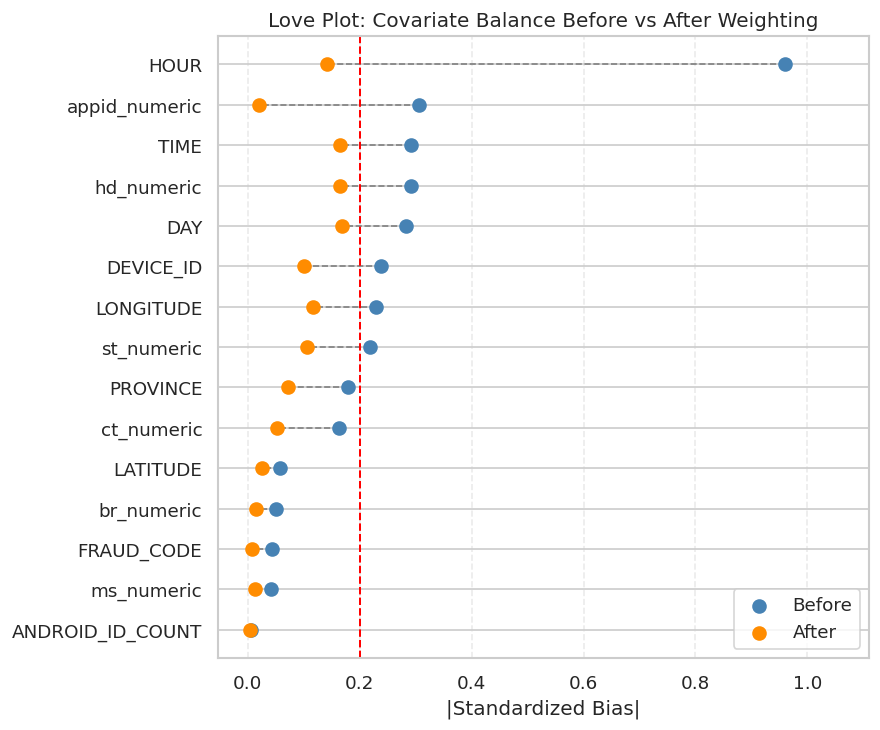


Is balanced (all max |SB| after < threshold)? True
Mean max |SB| after: 0.0780522027682846


In [10]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

PROP_FILE = Path("propensity_scores.csv")
EVAL_FILE = Path(f"Models0/val_counterfactual_predictions_Behavioral.csv")
DATA_FILE = Path("preprocessed_test_data.csv")

EPSILON = 1e-9
BALANCE_THRESHOLD = 0.2

sns.set(style="whitegrid")
plt.rcParams.update({"figure.dpi": 120})

def sb(X_treat, X_pop, w=None):
    pop_mu = np.mean(X_pop, axis=0)
    pop_sd = np.std(X_pop, axis=0)
    pop_sd[pop_sd < EPSILON] = np.nan

    treat_mu = (
        np.average(X_treat, axis=0, weights=w)
        if w is not None
        else np.mean(X_treat, axis=0)
    )

    return np.nan_to_num(np.abs(treat_mu - pop_mu) / pop_sd, nan=0.)

prop_df = pd.read_csv(PROP_FILE)
eval_df = pd.read_csv(EVAL_FILE)
df_full = pd.read_csv(DATA_FILE, low_memory=False)

pi_cols = sorted([c for c in prop_df.columns if c.startswith("pi_hat_ad_")],
                 key=lambda s: int(s.split("_")[-1]))
ad_ids  = [int(c.split("_")[-1]) for c in pi_cols]
ad2idx  = {a:i for i,a in enumerate(ad_ids)}

df = (
    eval_df[["Unique_ID","Actual_Ad_ID","Actual_Y"]]
    .merge(prop_df[["Unique_ID"] + pi_cols], on="Unique_ID", validate="1:1")
    .reset_index(drop=True)
)

df_full = df_full[df_full["Unique_ID"].isin(df["Unique_ID"])].reset_index(drop=True)

df_full["hd_numeric"]    = (np.floor(df_full["TIME"]/3600) - 486).astype(int)
df_full["br_numeric"]    = pd.factorize(df_full["BRAND_ID"])[0]
df_full["ct_numeric"]    = pd.factorize(df_full["DATA"])[0]
df_full["ms_numeric"]    = pd.factorize(df_full["OPERATOR_ID"])[0]
df_full["st_numeric"]    = pd.factorize(df_full["PROVINCE"])[0]
df_full["appid_numeric"] = pd.factorize(df_full["MEDIA_PACKAGE_NAME"])[0]

base_cols = ["hd_numeric","br_numeric","ct_numeric","ms_numeric",
             "st_numeric","appid_numeric",
             "PROVINCE","DAY","HOUR","TIME",
             "LATITUDE","LONGITUDE","ANDROID_ID_COUNT","FRAUD_CODE","DEVICE_ID"]
base_cols = [c for c in base_cols if c in df_full.columns]

X_base = df_full[base_cols].copy()
for c in X_base.columns:
    if X_base[c].isnull().any():
        X_base[c] = (
            X_base[c].fillna(X_base[c].median())
            if pd.api.types.is_numeric_dtype(X_base[c])
            else X_base[c].fillna(X_base[c].mode()[0])
        )

X_bal = X_base.values
pi_hat = df[pi_cols].to_numpy()
A_actual = df["Actual_Ad_ID"].to_numpy()

def build_support(col):
    levels = np.sort(df_full[col].unique())
    mapper = {v:i for i,v in enumerate(levels)}
    mat = np.zeros((len(levels), len(ad_ids)), int)

    y_onehot = np.zeros((len(df), len(ad_ids)), int)
    for i,a in enumerate(A_actual):
        if a in ad2idx:
            y_onehot[i, ad2idx[a]] = 1

    for v, grp in df_full.groupby(col):
        mat[mapper[v]] = (y_onehot[grp.index].sum(0) > 0).astype(int)
    return mat, mapper

def pick(mat, col_vals, mapper):
    return mat[col_vals.map(mapper).to_numpy()]

hdmat, hdmap = build_support("hd_numeric")
brmat, brmap = build_support("br_numeric")
ctmat, ctmap = build_support("ct_numeric")
msmat, msmap = build_support("ms_numeric")
stmat, stmap = build_support("st_numeric")
apmat, apmap = build_support("appid_numeric")

FLT = (pick(stmat, df_full["st_numeric"], stmap) *
       pick(hdmat, df_full["hd_numeric"], hdmap) *
       pick(ctmat, df_full["ct_numeric"], ctmap) *
       pick(brmat, df_full["br_numeric"], brmap) *
       pick(msmat, df_full["ms_numeric"], msmap) *
       pick(apmat, df_full["appid_numeric"], apmap)).astype(int)

plain_SB_all = np.zeros((len(base_cols), len(ad_ids)))
for j,a in enumerate(ad_ids):
    treat = np.where(A_actual == a)[0]
    plain_SB_all[:,j] = sb(X_bal[treat], X_bal) if treat.size else np.nan

adj_SB = np.zeros((len(base_cols), len(ad_ids)))

for j,a in enumerate(ad_ids):

    elig  = np.where(FLT[:,j] == 1)[0]
    treat = np.where(A_actual == a)[0]
    treat_el = treat[np.isin(treat, elig)]

    if not treat_el.size:
        adj_SB[:,j] = np.nan
        continue

    w = 1.0 / (pi_hat[treat_el, j] + EPSILON)

    adj_SB[:,j] = sb(
        X_bal[treat_el],   # treated
        X_bal[elig],       # eligible population
        w
    )

max_plain = np.nanmax(plain_SB_all, axis=1)
max_adj   = np.nanmax(adj_SB, axis=1)

print("\n── Max |SB| before weighting ──")
print(pd.DataFrame({"feature": base_cols,
                    "max_SB_plain": max_plain}).to_string(index=False))

print("\n── Max |SB| after weighting ──")
print(pd.DataFrame({"feature": base_cols,
                    "max_SB_adj": max_adj}).to_string(index=False))

love_df = pd.DataFrame({"Before":max_plain,"After":max_adj}, index=base_cols)
love_df["Max"] = love_df[["Before","After"]].max(axis=1)
love_df = love_df.sort_values("Max", ascending=True)

fig, ax = plt.subplots(figsize=(7.5, len(love_df)*0.35 + 1))
ax.grid(True, axis='x', linestyle='--', alpha=0.4)

ax.hlines(y=love_df.index,
          xmin=0,
          xmax=love_df.values.max()*1.1,
          color="lightgray",
          linewidth=0.5)

for idx in love_df.index:
    ax.plot([love_df.loc[idx,"Before"], love_df.loc[idx,"After"]],
            [idx, idx],
            color='gray',
            linestyle='--',
            linewidth=1)

ax.scatter(love_df["Before"], love_df.index,
           color="steelblue", s=60, label="Before", zorder=3)

ax.scatter(love_df["After"], love_df.index,
           color="darkorange", s=60, label="After", zorder=3)

ax.axvline(BALANCE_THRESHOLD,
           color="red",
           linestyle="--",
           linewidth=1.2)

ax.set_xlabel("|Standardized Bias|")
ax.set_title("Love Plot: Covariate Balance Before vs After Weighting")
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

balanced = (max_adj < BALANCE_THRESHOLD).all()
print("\nIs balanced (all max |SB| after < threshold)?", balanced)
print("Mean max |SB| after:", np.mean(max_adj))
